## 問題設定

- アイテム集合 $E = {1, 2, ...,  L}$ が与えられる。
- この中からk個のアイテムを選びランキングしたものを $A = {a_1, a_2, ..., a_k}$ とする。これをユーザに表示する検索結果とする。
- $\bar{w}(a_k)$ をアイテム $a_k$ がユーザにとって好みである確率(ここでは誘引確率と呼ぶ)とする。今回の設定ではクリック率。
  - あ、じゃあこの誘引確率 $\bar{w}(a_k)$ って、報酬の条件付き期待値 $E_{p(r|a_k)}[r]$ のことっぽい??:thinking_face:
- ユーザの行動がカスケードモデルに従う場合、推薦アイテムリストの $k$ 番目のアイテムがユーザに走査される(i.e. クリックするか否かの判断対象になる...!) 確率は以下のようになる。
  - (i.e. 1~k-1番目のアイテムが全てクリックされない、同時確率...!:thinking_face:)

$$
\prod_{i=1}^{k-1} (1 - \bar{w}(a_i))
$$

- また、1~k番目の推薦アイテムのうち少なくとも1つのアイテムがクリックされる確率は...

$$
1 - \prod_{i=1}^{k} (1 - \bar{w}(a_i))
$$


## CascadeUCB1

- UCBをベースとしたランキングタスクに対するcontext-freeなbanditアルゴリズム
- 観測されたフィードバックとして、何番目のアイテムがクリックされたかを $C_{t}$ で表す。
  - 観測された報酬 $w_{t}(a_k^{(t)}) = \mathbb{1}(C_{t} = k)$

- **Cascade model上にbanditアルゴリズムを適用する際のポイントは、下記の目的関数　$f(A, w)$ を最大化するような推薦アイテムリストを選択すること!**
  - (i.e. 1~k番目の推薦アイテムのうち少なくとも1つのアイテムがクリックされる確率だ...!:thinking_face:)

$$
f(A, w) = 1 - \prod_{i=1}^{k} (1 - w(a_i))
A_{t} = \arg \max_{A \in \mathcal{A}} f(A, w)
$$

- CascadeUCB1の場合は、UCBスコアを考慮した $U_{t}(e)$ を用いて、以下のように推薦アイテムリストを選択する。

$$
U_{t}(e) = \hat{w}_{t-1}(e) + c_{t-1, T_{t-1}(e)}
\\
c_{t, s} = \sqrt{\frac{1.5 \log(t)}{s}}
$$

- ここで、
  - $\hat{w}_{t-1}(e)$ は、アイテム $e$ に対する誘引確率の推定値
    - 今回の場合は、アイテムeについて観測されたs個の重み(i.e. 即時報酬...!)の標本平均を用いる。
  - $T_{t}(e)$ は、アイテム $e$ の走査がステップ $t$ までに観測された関数。
- 最終的にフィードバックで更新した $U_t(e)$ を用いて、推薦アイテムリストを選択する。

$$
A_{t} = \arg \max_{A \in \mathcal{A}} f(A, U_{t})
\\
= \arg \max_{A \in \mathcal{A}} (1 - \prod_{i=1}^{k} (1 - U_{t}(a_i)))
$$

In [ ]:
import math
import random
from abc import ABC, abstractmethod
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import bernoulli
from tqdm import tqdm

In [ ]:
class Agent(ABC):
    @abstractmethod
    def get_list(self, k: int) -> list[int]:
        """Agentがユーザに見せるリストを生成する"""
        pass

    @abstractmethod
    def observe(self, a: list[int], click: int) -> None:
        """ユーザからのフィードバックを受け取り、パラメータを更新する"""
        pass


class Env(ABC):
    @abstractmethod
    def click(self, A: list[int]) -> int:
        """
        渡されたアイテムリストに基づいて、ユーザがクリックしたアイテムのインデックス C_{t} を返す。
        もし何もクリックしなかった場合は、-1を返す。
        あ、この問題設定は、Multiple PlaysのMABじゃなくて、通常のSingle PlayのMABなんだ。
        もしMultiple PlaysのMABの問題設定の場合は、ここがlist[int]を返すように変更する必要がありそう。
        """
        pass

    @abstractmethod
    def get_true_weights(self, A: list[int]) -> list[float]:
        """渡されたアイテムリストに基づいて、各アイテムの重み(=誘引確率)を返す"""
        pass

    @abstractmethod
    def optimal_weights(self, k: int) -> list[float]:
        """理想リスト(=最も誘引確率の高いアイテム上位k個)の重み(=誘引確率)を返す"""
        pass

In [1]:
class CascadingModelEnv(Env):
    def __init__(self, true_weights: list[float]):
        # 初期化時に、すべてのアイテム集合Eのクリック確率 p(e) を受け取る
        self.true_weights = true_weights

    def click(self, A: list[int]) -> int:
        for i, item_idx in enumerate(A):
            if self.true_weights[item_idx] > np.random.random():
                return i + 1
        return -1

    def get_true_weights(self, A: list[int]) -> list[float]:
        return [self.true_weights[i] for i in A]

    def optimal_weights(self, k: int) -> list[float]:
        return sorted(E, reverse=True)[:k]


## test
E = [0, 0.1, 0.2, 0.3]
env = CascadingModelEnv(E)

results = []
for i in range(1000):
    results.append(env.click([1, 2, 3]))

plt.xlabel("item_index")
plt.ylabel("click_freq")
plt.hist(results)

NameError: name 'Env' is not defined

In [5]:
class CascadeUCB1Agent(Agent):
    def __init__(self, E: list[float], p: float) -> None:
        self.t = 1
        self.counts = [1 for _ in range(len(E))]
        self.weights = [bernoulli.rvs(p=p) for _ in range(len(E))]

    def ucb(self, e: int) -> float:
        """UCB1アルゴリズムに基づいて、各アイテムのUCBスコアを計算する"""
        return self.weights[e] + math.sqrt(1.5 * math.log(self.t - 1) / self.counts[e])

    def get_list(self, k: int) -> list[int]:
        """k個の推薦アイテムリストを選択"""
        self.t += 1
        ucbs = [self.ucb(e) for e in range(len(E))]
        # UCBスコアの高い上位k個を選んで推薦アイテムリストとして返す
        return sorted(range(len(ucbs)), key=lambda i: ucbs[i], reverse=True)[:k]

    def is_click(self, click: int, k: int) -> int:
        """k番目のアイテムがクリックされたかを判定"""
        return 1 if click == k else 0

    def observe(self, a: list[int], click: int) -> None:
        """ユーザからのフィードバックを受け取り、パラメータを更新する"""
        if click == -1:
            # ユーザが何もクリックしなかったとみなし、全アイテムを見たと仮定する
            click = len(a)

        for i in range(min(len(a), click)):
            e = a[i]
            before_count = self.counts[e]
            self.counts[e] += 1
            self.weights[e] = ((before_count * self.weights[e]) + self.is_click(click, i + 1)) / self.counts[e]

In [6]:
def f(weights: list[float]) -> float:
    """f(w) = 1 - (1 - w1)(1 - w2)...(1 - wk)"""
    v = 1
    for w in weights:
        v *= 1 - w
    return 1 - v


def regret(optimal_weights: list[float], weights: list[float]) -> float:
    """即時のregretを計算"""
    return f(optimal_weights) - f(weights)


In [ ]:
def simulate(agent: Agent, env: Env, k: int, steps: int) -> list[float]:
    """シミュレーションを実行し、累積regretの履歴を返す"""

    optimal_weights = env.optimal_weights(k=k)

    cumulative_regret = 0
    regret_cumulative_history = []
    for i in tqdm(range(steps)):
        a = agent.get_list(k=k)
        click = env.click(a)
        agent.observe(a, click)

        setting_weights = env.get_true_weights(a)
        cumulative_regret += regret(optimal_weights, setting_weights)
        regret_cumulative_history.append(cumulative_regret)

    return regret_cumulative_history

100%|██████████| 100000/100000 [00:00<00:00, 188995.19it/s]


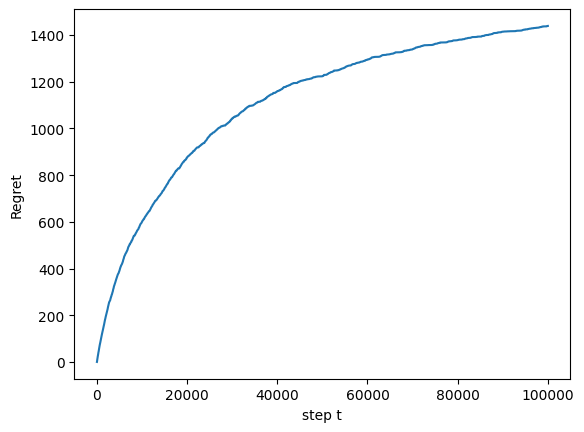

In [ ]:
true_weights = [0.3, 0.2, 0.25, 0.1, 0.1, 0.24, 0.2, 0.1, 0.21, 0.1]
env = CascadingModelEnv(true_weights=true_weights)
agent = CascadeUCB1Agent(E=true_weights, p=0.2)

regret_cumulative_history = simulate(agent=agent, env=env, k=3, steps=100000)

plt.xlabel("step t")
plt.ylabel("Regret")
plt.plot(regret_cumulative_history)

In [ ]:
def gen_items(weight_by_tag: dict[str, float], L: int, sigma=0.01) -> pd.DataFrame:
    """シミュレーション用の記事データを生成する
    - 今回はアイテムの特徴量ベクトルを表現するために、技術ブログサイトの記事を推薦する施策を仮定する。
    - 各記事には1~3個のタグが付与されており、タグによってクリック期待値 E_{p(r|e)}[r] が変化する。
    - タグそれぞれのクリック期待値の線型結合で、各記事のクリック期待値を計算する。
    - 各タグのクリック期待値は正規分布からサンプリングする。
    Args:
        tags: タグと線型結合時の重みの辞書
        L: アイテム数
        sigma: タグのクリック期待値をサンプリングする際の正規分布の標準偏差
    Returns:
        pd.DataFrame: 各記事に対する情報を持つDataFrame
        - id: 記事ID
        - weight: 記事のクリック期待値 E_{p(r|e)}[r]
        - feature: 各記事の特徴量ベクトル(タグのmulti-hot encoding)
    """
    tag_ids = list(weight_by_tag.keys())
    weights = []
    features = []
    for i in range(L):
        n = random.randint(1, 3)
        tag_samples = random.sample(tag_ids, n)

        w = 0
        one_hot = []
        for t in tag_ids:
            if t in tag_samples:
                w += random.gauss(weight_by_tag[t], sigma)
                one_hot.append(1)
            else:
                one_hot.append(0)

        vec = np.array(one_hot)
        features.append(vec.reshape(len(vec), 1))
        weights.append(w)

    df = pd.DataFrame({"id": list(range(len(weights))), "weight": weights, "feature": features})
    return df


weight_by_tag = {
    "AWS": 0.03,
    "Docker": 0.2,
    "Elasticsearch": 0.15,
    "GCP": 0.08,
    "Git": 0.05,
    "NLP": 0.19,
    "Rust": 0.23,
    "Scala": 0.14,
    "機械学習": 0.15,
    "強化学習": 0.20,
}
df = gen_items(weight_by_tag=weight_by_tag, L=10)
df.head(5)

,id,weight,feature
0,0,0.238902,"[[0], [0], [0], [0], [0], [0], [1], [0], [0], ..."
1,1,0.621864,"[[0], [0], [0], [0], [0], [0], [1], [1], [0], ..."
2,2,0.500644,"[[0], [0], [0], [0], [0], [0], [1], [1], [1], ..."
3,3,0.242067,"[[1], [0], [0], [0], [0], [0], [0], [0], [0], ..."
4,4,0.145878,"[[0], [0], [1], [0], [0], [0], [0], [0], [0], ..."


CascadeLinTSは、結局、腕の選び方は通常のLinTSと同じで、パラメータ更新(i.e. 学習)時に、ユーザの行動がカスケードモデルに従うことを考慮しているだけ、という認識...!:thinking_face:

- アイテムごとの誘引確率の推定値を、以下のように定義する

$$
w(e) := X_{e}^T \theta
$$

In [13]:
class CascadeLinTSAgent(Agent):
    def __init__(self, d: int, sigma: float, features: pd.DataFrame) -> None:
        self.sigma = sigma
        self.features = features
        self.InvM = np.eye(d)
        self.B = np.zeros(d).reshape(d, 1)

    def get_list(self, k: int) -> list[int]:
        before_theta = (self.sigma**-2) * self.InvM.dot(self.B)
        theta = np.random.multivariate_normal(mean=before_theta.ravel(), cov=self.InvM)
        weights = self.features["feature"].apply(lambda x: x.T.dot(theta)).to_list()
        return sorted(range(len(weights)), key=lambda i: weights[i], reverse=True)[:k]

    def is_click(self, click: int, k: int) -> int:
        return 1 if click == k else 0

    def observe(self, a: list[int], click: int) -> None:
        if click == -1:
            # ユーザが何もクリックしなかった場合は、1~k番目の全ての推薦アイテムを走査したと仮定する
            click = len(a)

        for i in range(min(len(a), click)):
            e = a[i]
            x = self.features[self.features["id"] == e]["feature"].to_list()[0]

            # 逆行列W^{-1}の更新式
            self.InvM = self.InvM - (self.InvM.dot(x).dot(x.T).dot(self.InvM)) / (
                x.T.dot(self.InvM).dot(x) + self.sigma**2
            )

            # パラメータBの更新式
            if self.is_click(click, i + 1):
                self.B = self.B + x

100%|██████████| 10000/10000 [02:25<00:00, 68.71it/s]


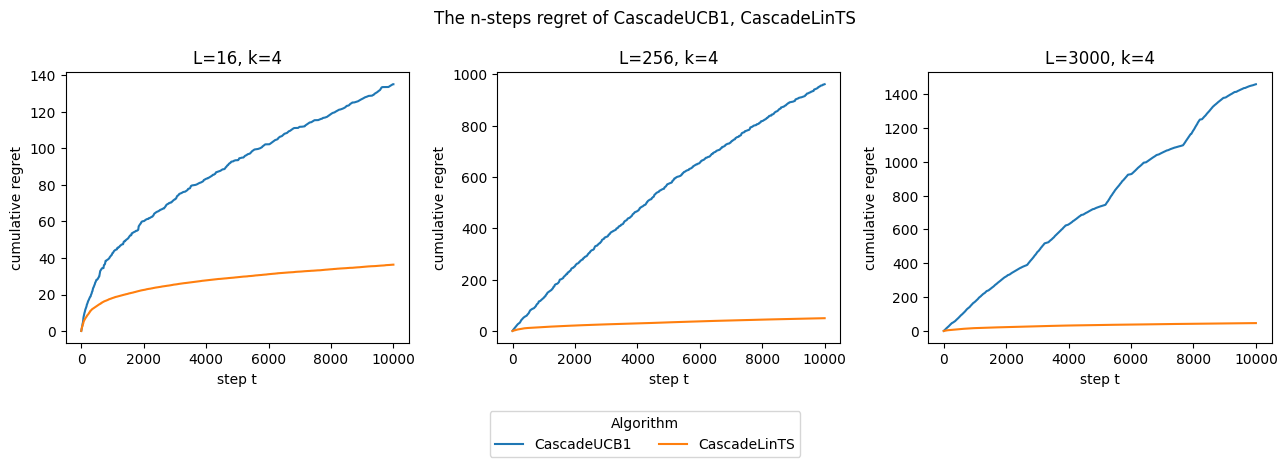

In [ ]:
k = 4
L = [16, 256, 3000]
steps = 10000

weight_by_tag = {
    "AWS": 0.1,
    "Docker": 0.2,
    "Elasticsearch": 0.15,
    "GCP": 0.08,
    "Git": 0.05,
    "NLP": 0.23,
    "Rust": 0.3,
    "Scala": 0.18,
    "機械学習": 0.25,
    "強化学習": 0.2,
}

fig = plt.figure(figsize=(13, 4))
fig.suptitle("The n-steps regret of CascadeUCB1, CascadeLinTS")

for i, l in enumerate(L):
    df = gen_items(weight_by_tag=weight_by_tag, L=l)
    true_weights = df["weight"].to_list()

    env = CascadingModelEnv(true_weights=true_weights)

    cascadelints_agent = CascadeLinTSAgent(d=len(weight_by_tag), sigma=1, features=df.drop("weight", axis=1))
    cascadeucb_agent = CascadeUCB1Agent(E=true_weights, p=0.2)

    cascadeucb1_regret_cumulative_history = simulate(agent=cascadeucb_agent, env=env, k=k, steps=steps)
    cascadelints_regret_cumulative_history = simulate(agent=cascadelints_agent, env=env, k=k, steps=steps)

    ax = fig.add_subplot(1, 3, i + 1)
    ax.set_title(f"L={l}, k=4")
    ax.plot(cascadeucb1_regret_cumulative_history, label="CascadeUCB1")
    ax.plot(cascadelints_regret_cumulative_history, label="CascadeLinTS")
    ax.set_xlabel("step t")
    ax.set_ylabel("cumulative regret")

fig.legend(
    ["CascadeUCB1", "CascadeLinTS"],
    loc="upper center",
    borderaxespad=0.1,
    title="Algorithm",
    bbox_to_anchor=(0.5, -0.02),
    ncol=2,
)
fig.tight_layout()
plt.show()